In [1]:
import tifffile as tiff
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import SimpleITK as sitk
from skimage.filters import threshold_otsu
from scipy.ndimage import minimum_filter, label

In [2]:
folder_xct = Path(r'E:\temporal\volumenes\32+33+34+35\33')

filename_xct = folder_xct / 'frontal_cropped.tif'

output_folder = folder_xct / 'output'

output_folder.mkdir(exist_ok=True)

xct = tiff.imread(filename_xct)
xct = np.swapaxes(xct, 0, 1)
xct = np.swapaxes(xct, 1, 2)

print(xct.shape)

(3282, 1900, 300)


In [19]:

def resize_image(original_image, size, show = False):
    width, height = original_image.size
    if show:
        print(f"The original image size is {width} wide x {height} tall")

    resized_image = original_image.resize(size)
    width, height = resized_image.size
    if show:
        print(f"The resized image size is {width} wide x {height} tall")
    return np.array(resized_image)

def calculate_new_dimensions(original_resolution, new_resolution, original_dimensions):
    # Calculate the original dimensions in real-world units
    original_width, original_height = original_dimensions
    real_world_width = original_width * original_resolution
    real_world_height = original_height * original_resolution

    # Calculate the new dimensions in pixels
    new_width = int(real_world_width / new_resolution)
    new_height = int(real_world_height / new_resolution)

    return new_width, new_height

def get_brightest(d):
    data = d.copy()
    #turn to 0 the values below 255
    data[data < 255] = 0
    #calculate the max of each image
    max_values = np.sum(data, axis=(0, 1))
    
    return np.argmax(max_values)

def paste_image_center(img1_array, img2_array):
    # Convert numpy arrays to PIL Images
    img1 = Image.fromarray(img1_array)
    img2 = Image.fromarray(img2_array)

    # Create a new image of zeros with the same shape as img1
    new_img = Image.fromarray(np.zeros_like(img1_array))

    # Calculate the position for the second image
    position = ((new_img.size[0]-img2.size[0])//2, (new_img.size[1]-img2.size[1])//2)

    # Paste the second image onto the new image
    new_img.paste(img2, position)

    # Convert back to numpy array and return
    return np.array(new_img)

def label_objects(image):
    labeled_image, num_features = label(image)
    output_image = np.zeros_like(image)
    
    indices = np.where(labeled_image > 0)
    indices = list(zip(indices[0], indices[1]))
    
    # Label the object nearest to the top edge
    top_object = min(indices, key=lambda x: x[0])
    output_image[top_object] = 100
    indices.remove(top_object)
    
    if indices:
        # Label the object nearest to the left edge
        left_object = min(indices, key=lambda x: x[1])
        output_image[left_object] = 175
        indices.remove(left_object)
    
    # Label the remaining objects
    for idx in indices:
        output_image[idx] = 255
    
    return output_image

def plot_images(images, figsz = (5, 5)):
    fig, axs = plt.subplots(1, len(images), figsize=figsz)
    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

def circles(img):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw circles on
    circle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        # Draw the circle
        cv2.circle(circle_img, (int(x), int(y)), int(radius), (255, 255, 255), -1)

        break

    return circle_img

def rectangles(img, thickness=2):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw rectangles on
    rectangle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        # Draw the rectangle contour
        cv2.rectangle(rectangle_img, (x, y), (x+w, y+h), (255, 255, 255), thickness)

    return rectangle_img > 0

import cv2
import numpy as np

def draw_bounding_box(image):

    # Convert binary image to grayscale
    image = (image * 255).astype(np.uint8)

    # Create a new binary image of the same size
    output_image = np.zeros_like(image)

    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, draw the bounding box on the new image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(output_image, (x, y), (x+w, y+h), (255), -1)

    return output_image > 0

def find_rectangle_centers(image):
    # Ensure the image is binary
    assert np.array_equal(image, image.astype(bool)), "Image must be binary"

    # Find connected components in the image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image.astype('uint8'))

    # The first component is the background, so ignore it
    return centroids[1:]

def paint_points_on_image(points, image):
    # Create a copy of the image to avoid modifying the original
    image_copy = np.copy(image)

    # Convert the image to RGB if it's grayscale
    if len(image_copy.shape) == 2:
        image_copy = np.stack((image_copy,)*3, axis=-1)

    # Paint each point in red
    for point in points:
        x, y = point
        image_copy[int(y), int(x)] = [255, 0, 0]  # RGB for red

    return image_copy

def find_local_minima(image, size=3, threshold=50):
    # Apply the minimum filter
    filtered_image = minimum_filter(image, size)

    # Find local minima
    local_minima = image == filtered_image

    # Apply threshold
    local_minima = np.logical_and(local_minima, image <= threshold)

    # The result is a boolean mask where True indicates local minima
    return local_minima

def find_brightest_ut(volume):
    # Find the brightest slice
    brightest_slice = np.argmax(np.sum(volume, axis=(0, 1)))

    return brightest_slice

def paint_binary_points(shape, points):
    # Create an empty image of the specified shape
    image = np.zeros(shape, dtype=np.uint8)

    # Iterate over the points
    for point in points:
        # Round the coordinates to the nearest integer
        y,x = tuple(int(round(coord)) for coord in point)
        # cv2.circle(image, (y,x), 5, (255), -1)
        # Draw the point on the image
        image[x,y] = 255

    return image.astype(np.uint8)

In [58]:
import cv2

def paint_binary_points(shape, points):
    # Create an empty image of the specified shape
    image = np.zeros(shape, dtype=np.uint8)

    # Iterate over the points
    for point in points:
        # Round the coordinates to the nearest integer
        y,x = tuple(int(round(coord)) for coord in point)
        # Draw a circle of radius 50 on the image
        cv2.circle(image, (y,x), 100, (255), -1)

    return image.astype(np.uint8)

In [59]:
id = get_brightest(xct)

image = xct[:,:,id]

print(image.shape)

thresh = threshold_otsu(image)

print(thresh)

thresholded = image > thresh

#fill holes
thresholded = ndimage.binary_fill_holes(thresholded)

xct_centers  = find_rectangle_centers(thresholded)


(3282, 1900)
150


(3, 2)


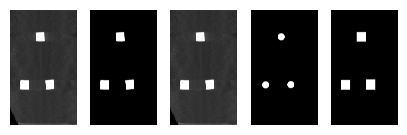

In [60]:
# To delete the element at index 1 along axis 0
xct_centers = np.delete(xct_centers, 3, axis=0)

print(xct_centers.shape)

centers_painted_xct = paint_binary_points(thresholded.shape, xct_centers)

xct_mask = draw_bounding_box(thresholded) * 1

plot_images([image, thresholded, paint_points_on_image(xct_centers, image), centers_painted_xct, xct_mask])

In [61]:
original_dimensions = (xct.shape[0], xct.shape[1])
new_dimensions = calculate_new_dimensions(0.022, 1, original_dimensions)
print(f"The new dimensions are {new_dimensions}")
resized = resize_image(Image.fromarray(centers_painted_xct), new_dimensions[::-1])

print(resized.shape)

The new dimensions are (72, 41)
(72, 41)


In [62]:
#save as tiff
tiff.imsave(output_folder / 'centers_2.tif', resized)

C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_20548\1150160756.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'centers_2.tif', resized)


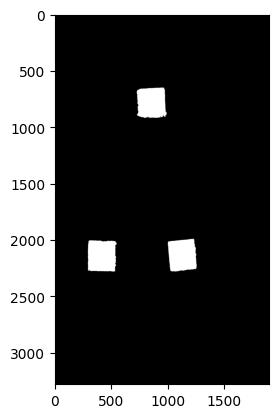

In [63]:
plt.imshow(thresholded, cmap='gray')